TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* complex to real in reconstruction loss. overall phase shifts shouldn't change this metric. Figure out the linear algebra least squares stuff.

In [1]:
import tf_helper as hh

2022-10-05 18:35:33.730460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 18:35:33.819542: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 18:35:34.181368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-05 18:35:34.181414: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
path = '/home/ollie/mnt/sys/Documents/scratch/PtychoNN/TF2'

import sys
sys.path.append(path)

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

In [4]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Oct  5 18:35:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 55%   51C    P8    35W / 420W |  20318MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

In [5]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

In [6]:
matplotlib.rcParams['font.size'] = 12

### Some training parameters

In [7]:
h,w=64,64
nepochs=20
wt_path = 'wts4' #Where to store network weights
batch_size = 32

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [8]:
data_diffr = np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
data_diffr.shape

(161, 161, 256, 256)

In [9]:
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

  0%|          | 0/161 [00:00<?, ?it/s]

In [10]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

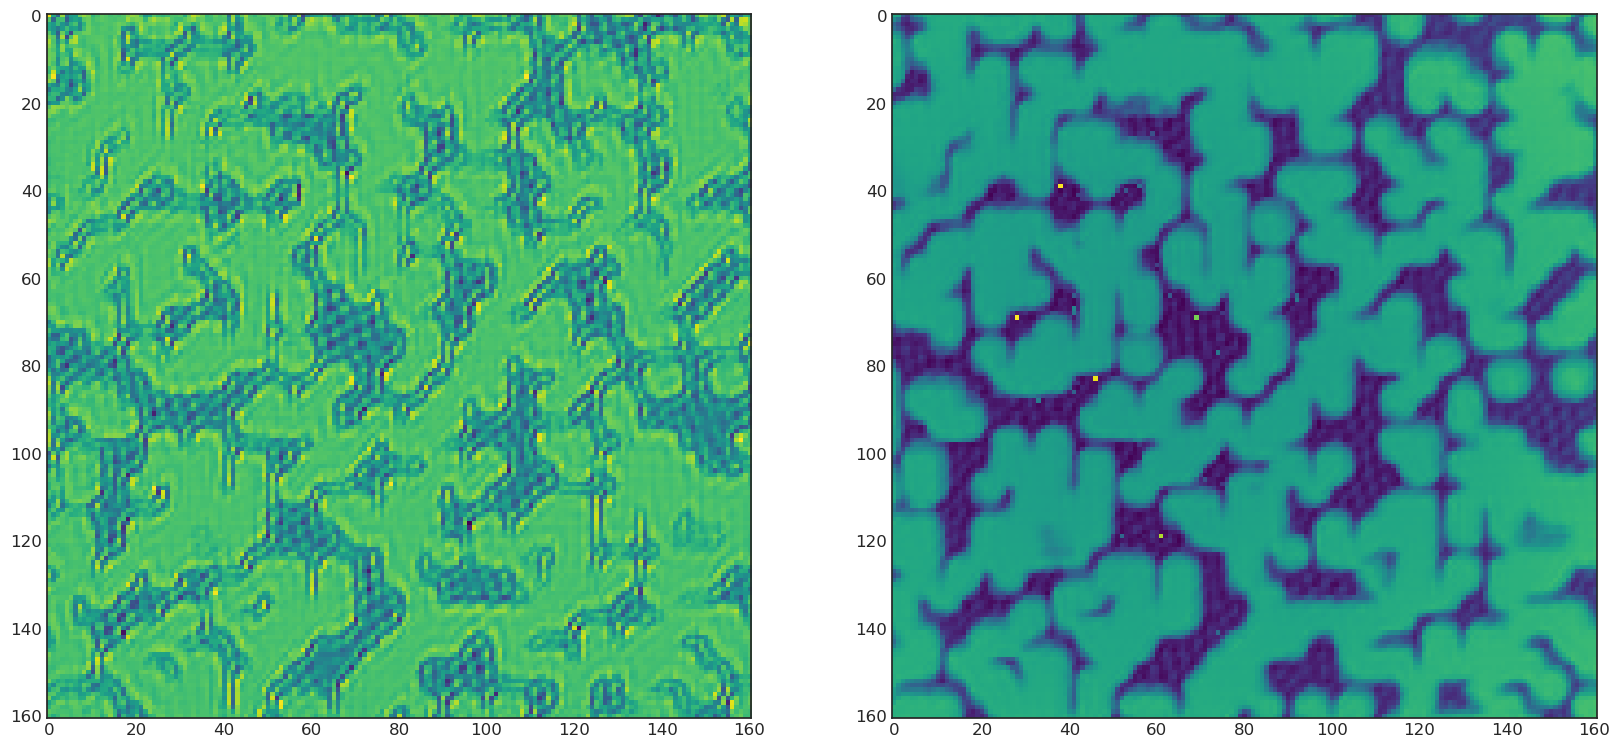

In [11]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [12]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [13]:
from xrdc import fourier as f

In [14]:
filt = f.lowpass_g(.6, np.ones(h))
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 2) + 1e-9
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])

2022-10-05 18:36:00.853442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 18:36:00.854255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 18:36:00.854419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 18:36:00.854533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

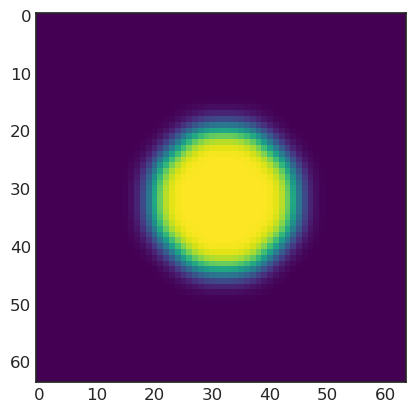

In [15]:
plt.imshow(probe)

In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def blowup(img):
    N = img.shape[0]
    assert img.shape[1] == N
    cropped = img[N // 4: -N // 4, N // 4: -N // 4]
    return resize(cropped.copy(), (N, N))


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

# # resize to fill the grid better
# X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

tmp1, tmp2 = Y_I_train, Y_I_test
Y_I_train = Y_I_train *  probe[None, ..., None]
Y_I_test = Y_I_test *  probe[None, ..., None]

Y_I_test /= (Y_I_train.max())
Y_I_train /= (Y_I_train.max())

X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])
X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

(16100, 64, 64, 1) (3600, 64, 64, 1)


In [17]:
Y_I_train.shape

(16100, 64, 64, 1)

In [18]:
# optional: use amplitude instead of intensity. If this is changed, the model has to be changed correspondingly
X_train = tf.sqrt(X_train)
X_test = tf.sqrt(X_test)

In [22]:
i = 100

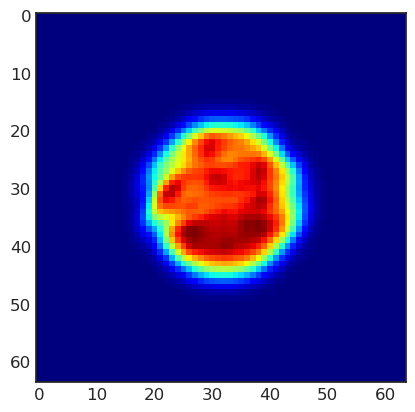

In [23]:
plt.imshow((tmp1 * probe[None, ..., None])[i], cmap = 'jet')

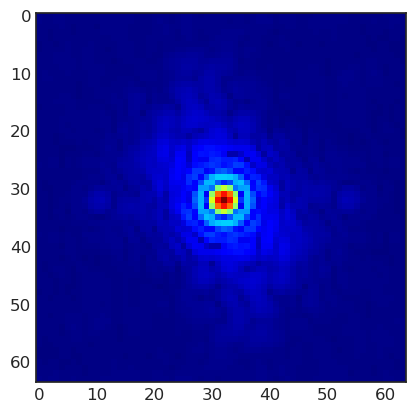

In [20]:
plt.imshow(np.squeeze(X_train[i]), cmap = 'jet')

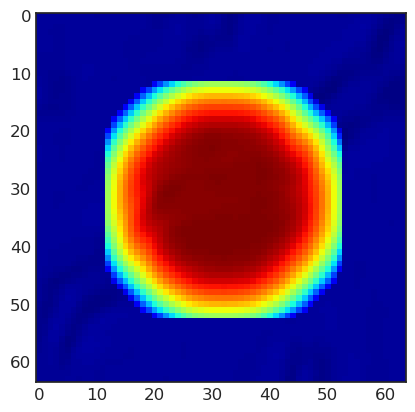

In [21]:
#plt.imshow(np.log(np.squeeze(Y_I_train[i])[16:-16, 16:-16]), cmap = 'jet')
plt.imshow(np.log(np.squeeze(Y_I_train[i])), cmap = 'jet')

### Recover shift between scan points

In [23]:
Y_I_test.shape

(3600, 64, 64, 1)

In [24]:
import numpy as np
import scipy.signal

def cross_image(im1, im2):
    # get rid of the color channels by performing a grayscale transform
    # the type cast into 'float' is to avoid overflows
    im1_gray = im1#np.sum(im1.astype('float'), axis=2)
    im2_gray = im2#np.sum(im2.astype('float'), axis=2)

    # get rid of the averages, otherwise the results are not good
    im1_gray -= np.mean(im1_gray)
    im2_gray -= np.mean(im2_gray)

    # calculate the correlation image; note the flipping of onw of the images
    return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

In [176]:
a1 = Y_I_test[101].squeeze()#[:, 32]
a2 = Y_I_test[104].squeeze()#[:, 32]

# a11 = np.ones_like(a1)
# ref = cross_image(a11, a11) + 1e-9

In [177]:
corr_img = cross_image(a1, a2)

In [178]:
np.unravel_index(np.argmax(corr_img), corr_img.shape)

(32, 32)

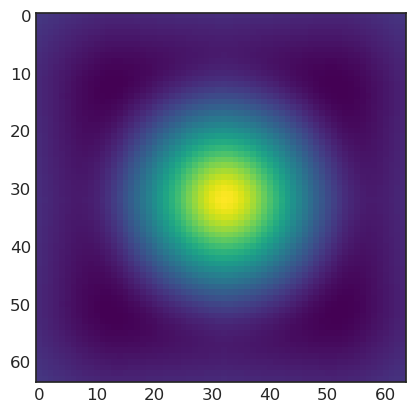

In [181]:
plt.imshow(corr_img)

In [117]:
from xrdc import fourier as f

### Full diffraction, no probe envelope:

In [185]:
X_train.max()

5.9804506

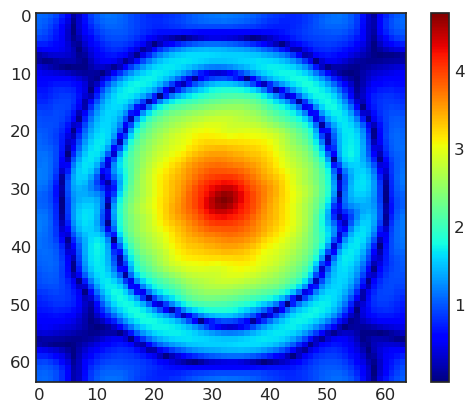

In [187]:
forward = (np.absolute(f.fftshift(f.fft2(f.gf(X_train[i], 0.).squeeze()))))

plt.imshow(np.log(1 + f.gf(forward, 0)), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [19]:
# !ln ../../xrd_clustering/notebooks/tf_helper.py

In [19]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np



def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [20]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda
from xrdc import fourier as f

from importlib import reload
reload(hh)

import math

In [21]:
def get_mask(input, support_threshold):
#     mask = tf.where(input > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
    
    mask = tf.where(tprobe[16:-16, 16:-16, :] > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    return mask

In [22]:
tf.keras.backend.clear_session()
np.random.seed(1)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)

#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])

# Add real space support
# support = Lambda(lambda x: get_mask(x, .01), name='support')(decoded1)
# obj = Lambda(lambda x: x[0] * tf.cast(x[1], tf.complex64),
#                             name='masked_obj')([obj, support])

# Diffracted intensity
padded_obj, pred_diff = hh.pad_and_diffract(obj, h, w)

# Diffracted amplitude
pred_diff = tf.sqrt(pred_diff)


#autoencoder = Model(input_img, pred_diff)
autoencoder = Model([input_img], [pred_diff, padded_obj])


# TODO: is the first target vector in training matched to only the first model output for loss
# calculation purposes, etc.? (yes.. but let's make sure)
# Make an auxiliary model that exposes the real space object reconstruction
# obj_layer_out = autoencoder.get_layer('obj').output
# aux_model = tf.keras.Model(inputs=autoencoder.inputs,
#                            outputs=autoencoder.outputs + [obj_layer_out])

#autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

# The second output exposes the real space object reconstruction but does not contribue to the training loss,
# but it's used to calculate reconstruction errors for validation
autoencoder.compile(optimizer='adam', loss=['mean_absolute_error', 'mean_absolute_error'],
                    loss_weights = [1., 0.]
#                     {autoencoder.outputs[0].name.split('/')[0]: 'mean_absolute_error'}
                   )

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [36]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# history=autoencoder.fit(X_train, X_train, shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=nepochs, validation_split = 0.05, callbacks=[reduce_lr, earlystop])

history=autoencoder.fit([X_train], [X_train, Y_I_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=10, validation_split = 0.05, callbacks=[reduce_lr, earlystop])

a, b = autoencoder.predict([X_test])

Epoch 1/10
478/478 [==============================] - 5s 10ms/step - loss: 0.0076 - tf.math.sqrt_loss: 0.0076 - padded_obj_loss: 0.0301 - val_loss: 0.0077 - val_tf.math.sqrt_loss: 0.0077 - val_padded_obj_loss: 0.0314 - lr: 0.0010
Epoch 2/10
478/478 [==============================] - 5s 10ms/step - loss: 0.0075 - tf.math.sqrt_loss: 0.0075 - padded_obj_loss: 0.0325 - val_loss: 0.0073 - val_tf.math.sqrt_loss: 0.0073 - val_padded_obj_loss: 0.0334 - lr: 0.0010
Epoch 3/10
478/478 [==============================] - 5s 10ms/step - loss: 0.0074 - tf.math.sqrt_loss: 0.0074 - padded_obj_loss: 0.0348 - val_loss: 0.0074 - val_tf.math.sqrt_loss: 0.0074 - val_padded_obj_loss: 0.0367 - lr: 0.0010
Epoch 4/10
478/478 [==============================] - 5s 10ms/step - loss: 0.0072 - tf.math.sqrt_loss: 0.0072 - padded_obj_loss: 0.0369 - val_loss: 0.0072 - val_tf.math.sqrt_loss: 0.0072 - val_padded_obj_loss: 0.0382 - lr: 0.0010
Epoch 5/10
478/478 [==============================] - 5s 11ms/step - loss: 0.007

In [25]:
# a, b = aux_model.predict(X_train)

In [26]:
def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)

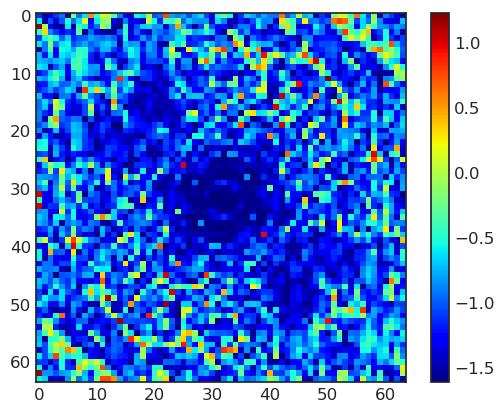

In [37]:
plt.imshow(np.log(.2 + np.abs((a[i] - X_test[i]) / (X_test[i] + 1e-9))), cmap ='jet')
plt.colorbar()

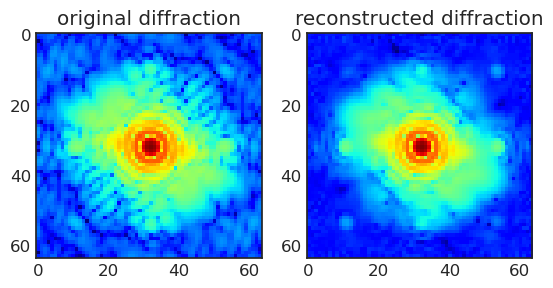

In [38]:
i = 630
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

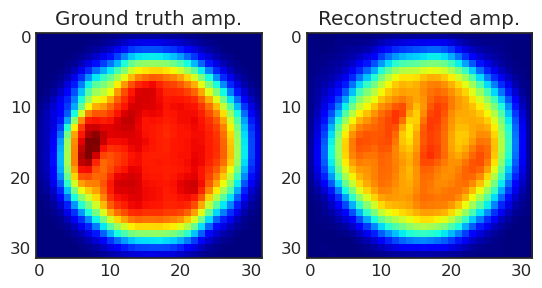

In [40]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.real(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

In [47]:
np.real(b[i]).min()

-0.0030227276

In [41]:
Y_I_test[i]

array([[[7.57699722e-10],
        [7.49069931e-10],
        [7.54082892e-10],
        ...,
        [7.19353088e-10],
        [7.18577043e-10],
        [7.17048459e-10]],

       [[7.59376046e-10],
        [7.49865856e-10],
        [7.55703081e-10],
        ...,
        [7.31648229e-10],
        [7.30214634e-10],
        [7.24699899e-10]],

       [[7.53451869e-10],
        [7.44711197e-10],
        [7.50893573e-10],
        ...,
        [7.31708050e-10],
        [7.32498174e-10],
        [7.25175811e-10]],

       ...,

       [[7.31828841e-10],
        [7.24276740e-10],
        [7.31783884e-10],
        ...,
        [7.51419940e-10],
        [7.52900546e-10],
        [7.44913683e-10]],

       [[7.29085825e-10],
        [7.22848885e-10],
        [7.31939903e-10],
        ...,
        [7.61091103e-10],
        [7.67146042e-10],
        [7.54624305e-10]],

       [[7.29315744e-10],
        [7.23142915e-10],
        [7.32293453e-10],
        ...,
        [7.63914425e-10],
        [7.7579

In [53]:
y_true = [[1.]]
y_pred = [[1.j]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_true, y_pred).numpy()

1.4142135623730951

In [ ]:
tf.keras.losses.

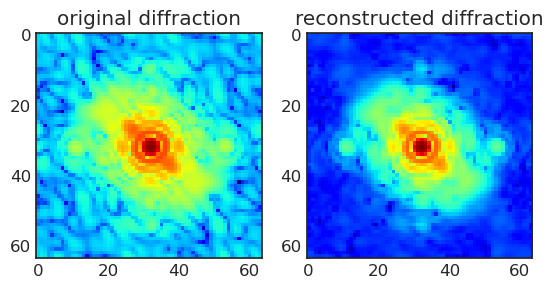

In [38]:
i = 609
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

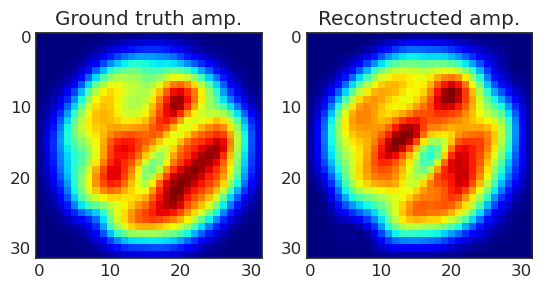

In [39]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

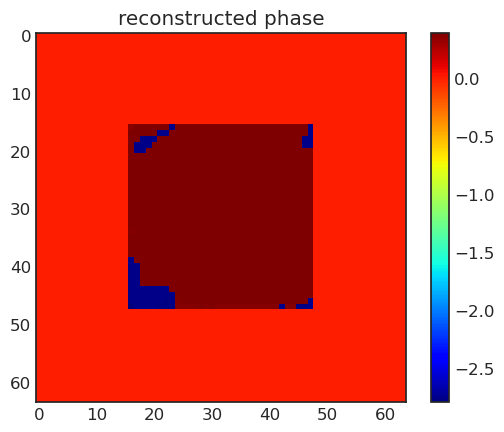

In [44]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')
plt.colorbar()

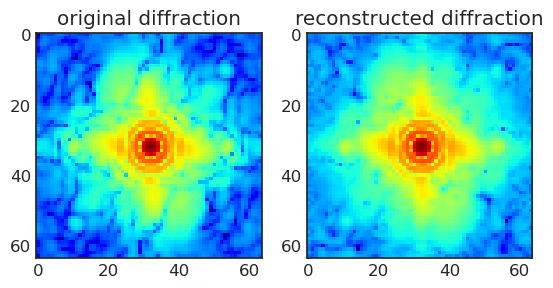

In [37]:
i = 620
aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('original diffraction')
plt.imshow(.1 + np.log(X_test[i]), cmap = 'jet')
#plt.colorbar()

plt.subplot(aa, bb, 2)
plt.title('reconstructed diffraction')
plt.imshow(.1 + np.log(a[i]), cmap = 'jet')
#plt.colorbar()

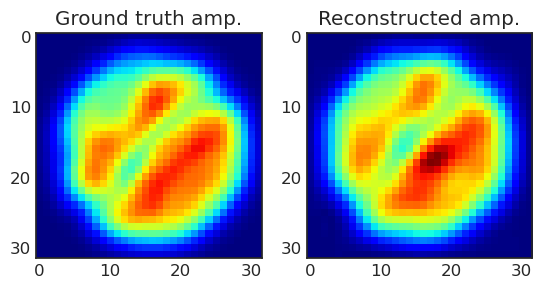

In [240]:
off = 1
i = 610
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

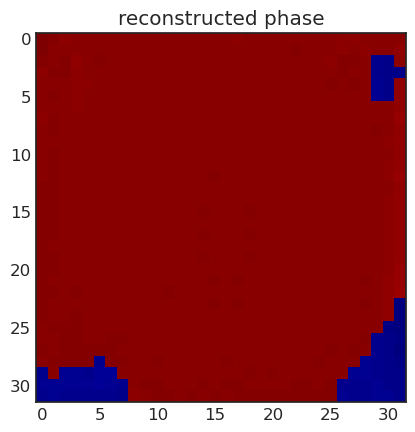

In [208]:
plt.title('reconstructed phase')
plt.imshow((np.angle(b))[i], cmap = 'jet')

In [134]:
# !ln ../../xrd_clustering/notebooks/visualization.py

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [146]:
import visualization as vis
reload(vis)

<module 'visualization' from '/home/ollie/mnt/sys/Documents/scratch/PtychoNN/TF2/visualization.py'>

ground truth


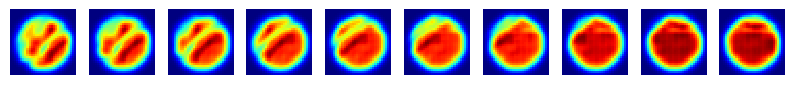

reconstruction


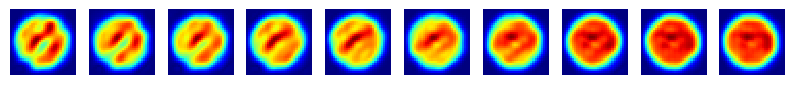

In [150]:
print('ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10])


print('reconstruction')
vis.display_imgs(np.absolute(b)[i:i + 10])

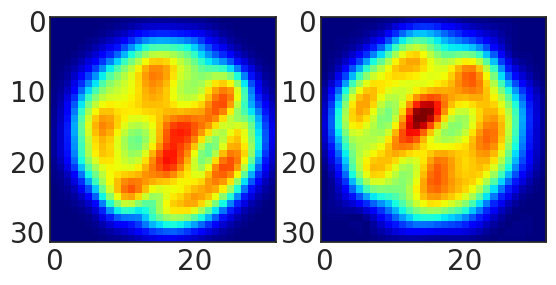

In [110]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

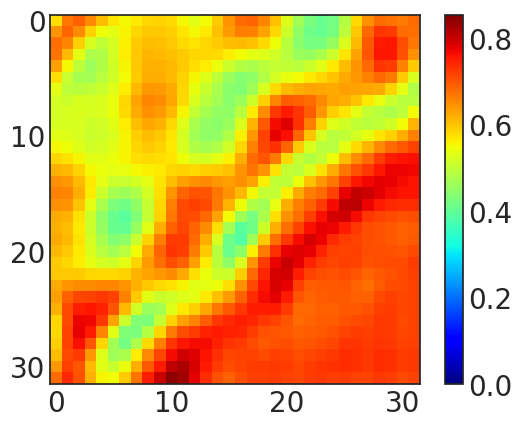

In [98]:
cropshow((tmp2[i] * norm), cmap = 'jet', vmin = 0, vmax = vmax)# tmp2.min(), vmax = tmp2.max())
plt.colorbar()

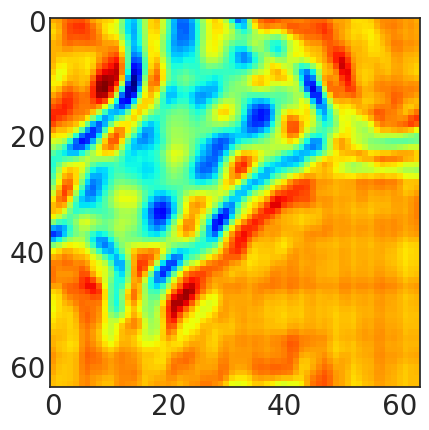

In [70]:
plt.imshow(np.log(off + tmp2[i + 1]), cmap = 'jet')

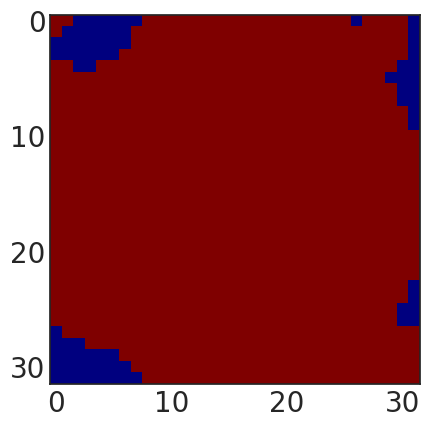

In [61]:
plt.imshow((np.angle(b))[i], cmap = 'jet')

In [40]:
from xrdc import fourier as f

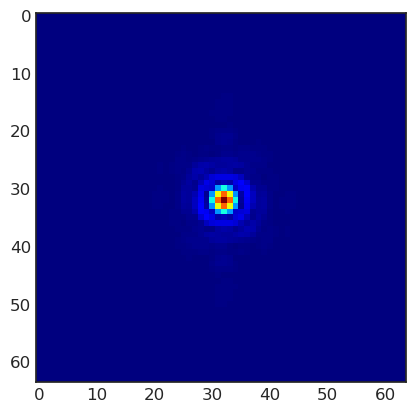

In [153]:
plt.imshow(np.squeeze(X_train[1000]), cmap = 'jet')

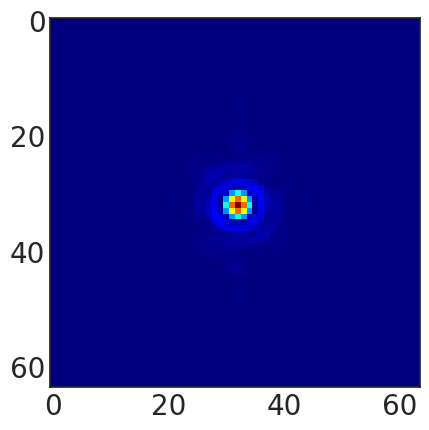

In [78]:
plt.imshow(np.squeeze(X_train[1000]), cmap = 'jet')

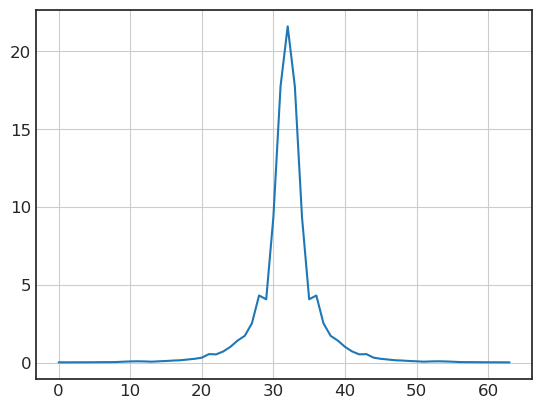

In [36]:
plt.plot(X_train[i].sum(axis = 0))
plt.grid()

## Training metrics

In [53]:
hist.history.keys()

dict_keys(['loss', 'tf.math.sqrt_loss', 'padded_obj_loss', 'val_loss', 'val_tf.math.sqrt_loss', 'val_padded_obj_loss', 'lr'])

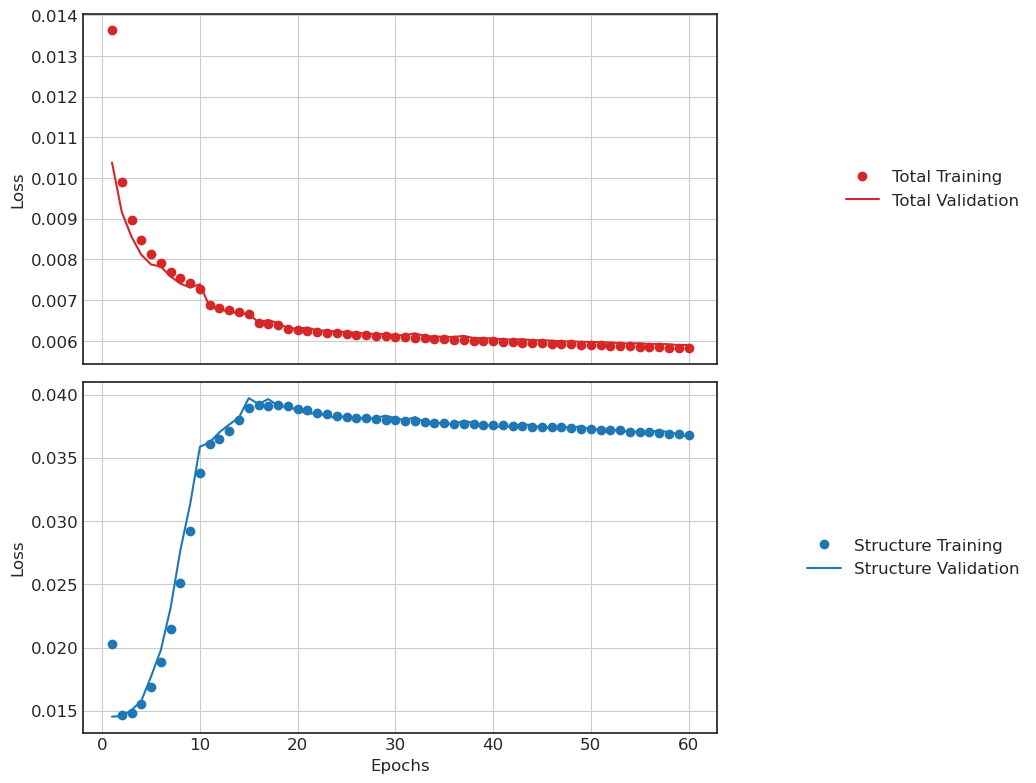

In [54]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 12

f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()

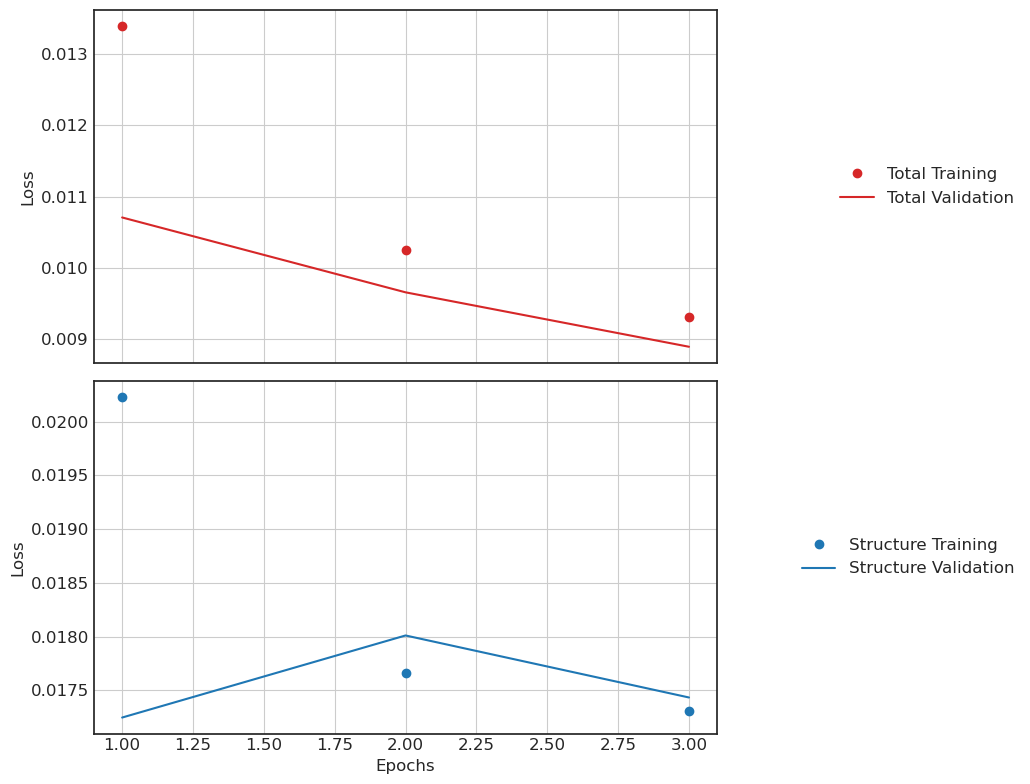

In [105]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 12

f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()

In [56]:
np.save(path+'str_history', history.history)

In [61]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))

In [62]:
!du -sh wts4.h5

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
13M	wts4.h5
